<h1 style="color:rgb(0,120,170)">OEAW AI Summer School 2021 - Day 1: </h1>
<h2 style="color:rgb(0,120,170)">Introduction to Deep Learning - My first Neural Network</h2>

This notebook serves as a sanity check whether everything works on your computer and is also the basis and starting point for the exercises of today. Press Crtl/cmd + Enter to run a cell.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import os
import numpy as np  # added in exercise 1
from scipy.signal import savgol_filter  # added in exercise 1
%config InlineBackend.figure_formats = ['svg']  # added in exercise 1
from sklearn.metrics import confusion_matrix  # added in exercise 2
import seaborn as sns  # added in exercise 2

# Hyperparameters for the Training Procedure

In [ ]:
args = SimpleNamespace(batch_size=8, test_batch_size=1000, epochs=1,
                       lr=0.005, momentum=0.5, seed=1, log_interval=100)  # values changed in exercise 3
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Data Loader

In [ ]:
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=True, download=True, # dataset name changed in exercise 5
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([ # dataset name changed in exercise 5
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

# How does the Data look like?

In [ ]:
print('There are', train_loader.dataset.targets.shape[0], 'samples for training and', test_loader.dataset.targets.shape[0], 'samples for testing.')
print('The format of the data is', train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension as vector is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

# A first architecture
This is a basic neural network with one input layer, one hidden layer and one output layer. You can play around with number of layers, number of units, weight initialization, dropout, batch normalization, activation functions...

In [5]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # input layer
        self.linear1 = nn.Linear(784, 1024)
        #hidden layers
        self.linear2 = nn.Linear(1024, 2048)
        self.linear3 = nn.Linear(2048, 1024)
        self.linear4 = nn.Linear(1024, 512)
        #output layer
        self.linear5 = nn.Linear(512, 10)
        
        self.dropout1 = nn.Dropout(p=0.2)  # values changed in exercise 3
        self.dropout2 = nn.Dropout(p=0.1)
        self.dropout3 = nn.Dropout(p=0.1)
        self.dropout4 = nn.Dropout(p=0.1)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(2048)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        #x = self.bn1(x)
        
        x = self.linear2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        #x = self.bn2(x)
        
        x = self.linear3(x)
        x = self.dropout3(x)
        x = F.relu(x)
        #x = self.bn3(x)
        
        x = self.linear4(x)
        x = self.dropout4(x)
        x = F.selu(x)
        
        x = self.linear5(x)
        x = F.log_softmax(x, dim=1)
        return x


# CNN architecture (two conv layers followed by three fully connected layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        #self.conv3 = nn.Conv2d(96, 80, 3)
        #self.conv4 = nn.Conv2d(80, 96, 3)
        self.fc1 = nn.Linear(64*5*5, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout2d(0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout2(x)
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = F.max_pool2d(x, 2, 2)

        #x = F.relu(self.conv3(x))
        #x = self.dropout2(x)

        #x = F.relu(self.conv4(x))
        #x = self.dropoutc(x)

        #print(x.shape)

        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(x, dim=1)
        return x

# This function trains the model.

In [6]:
def train(args, model, device, train_loader, optimizer, epoch, 
          loss_curve,  # added in exercise 1
          ):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #data = Variable(data.view(-1, input_dim))    #needs to be removed in exercise 6
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            loss_curve.append(loss.item())  # added in exercise 1

# This function evaluates the model on the test data

In [7]:
def test(args, model, device, test_loader, confusion_matrix):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #data = Variable(data.view(-1, input_dim))    #needs to be removed in exercise 6
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i, t in enumerate(target):  # added in exercise 2
                confusion_matrix[t.item(), pred[i].item()] += 1
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# This cell calls the model, starts the training and evaluates it on the test set

In [10]:
# Main
model = ConvNet().to(device) # model name changed in exercise 6
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum, weight_decay=0.0001)

loss_curve = []  # added in exercise 1
confusion_matrix = np.zeros([10,10], int)  # added in exercise 2

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch, loss_curve)  # loss_curve added in exercise 1
    test(args, model, device, test_loader, confusion_matrix)  # confusion_matrix added in exercise 2

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308565
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.198024
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.795030
Train Epoch: 1 [2400/60000 (4%)]	Loss: 1.876771
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.343911
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.014274
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.730972
Train Epoch: 1 [5600/60000 (9%)]	Loss: 1.492775
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.201110
Train Epoch: 1 [7200/60000 (12%)]	Loss: 1.379237
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.857818
Train Epoch: 1 [8800/60000 (15%)]	Loss: 1.485381
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.537698
Train Epoch: 1 [10400/60000 (17%)]	Loss: 1.133993
Train Epoch: 1 [11200/60000 (19%)]	Loss: 1.038894
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.620812
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.465610
Train Epoch: 1 [13600/60000 (23%)]	Loss: 1.166596
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.506536
Train Epoch: 1 [15200/60000 (25%)]	Loss: 1.173354
Train Epoch: 1 [16000/600

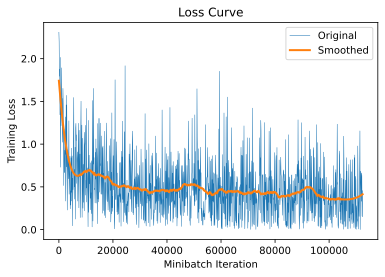

In [ ]:
# this cell was added in exercise 1

loss_curve_avg = savgol_filter(loss_curve, 151, 3) 


plt.plot(args.log_interval*np.arange(len(loss_curve)),loss_curve, label='Original', linewidth=0.5, alpha=1)
plt.plot(args.log_interval*np.arange(len(loss_curve)),loss_curve_avg, label='Smoothed', linewidth=2)
plt.xlabel('Minibatch Iteration')
plt.ylabel('Training Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

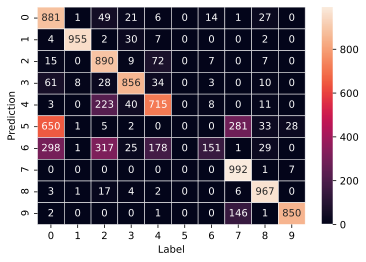

In [11]:
# this cell was added in exercise 2

ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', linewidths=.5)
plt.xlabel("Label") 
plt.ylabel("Prediction") 
plt.show()

In [ ]:
# this cell was added in exercise 4

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this cell was added in exercise 4
# the path will be different for your drive!

PATH = '/content/drive/MyDrive/work/hephy/oeawai21/exercises/solutions/trained_cnn.pt'

torch.save(model.state_dict(), PATH)

model = ConvNet()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# this cell was added in exercise 4

print(model)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
)


Done.